# Multilabel specialities from bibliovid 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Installing the transformers library and additional libraries if looking process 

!pip install -q transformers

# Code for TPU packages install
# !curl -q https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

     |████████████████████████████████| 1.5MB 14.2MB/s 
     |████████████████████████████████| 2.9MB 57.9MB/s 
     |████████████████████████████████| 890kB 57.7MB/s 


In [3]:
# Importing stock ml libraries
import pickle
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.model_selection import train_test_split
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
import nltk
from nltk.corpus import stopwords
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


Import des données et prétraitement du DataFrame

In [6]:
if True:
  data_folder = '/content/drive/MyDrive/PSTALN (1)/data/'
  df_bibliovid=pd.read_json('/content/drive/MyDrive/data/bibliovid.json')
  # df_cord=pd.read_json(data_folder+'cord19-metadata.json')
  # df_litcovid=pd.read_json(data_folder+'litcovid.json')
  df_bibliovid = df_bibliovid.dropna(subset=['abstract','topics'])
  df_bibliovid = df_bibliovid.drop(df_bibliovid[ df_bibliovid.abstract==''].index)
  df_bibliovid = df_bibliovid.drop(df_bibliovid[ df_bibliovid.topics==''].index)

In [7]:
df_bibliovid#.head()

,id,slug,title,has_other_authors,impact_factor,goals_plain,verbose_date,authors,document_link,specialties,category,journal,link,results,synthesis,strength_of_evidence_details,goals,methods,pubmed_id,doi,abstract,topics,author_list,publication_date
0,769,body-mass-index-and-risk-for-intubation-or-dea...,Body Mass Index and Risk for Intubation or Dea...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...",- Déterminer si l'obésité est associée à l'int...,31.07.2020,Anderson MR,https://www.acpjournals.org/doi/10.7326/M20-3214,"[{'id': 4, 'name': 'Anesthésie-Réanimation'}, ...","{'id': 6, 'name': 'Pronostique', 'icon': 'icon...","{'id': 41, 'name': 'Ann Intern Med'}",https://www.acpjournals.org/doi/10.7326/M20-3214,*Description de l'échantillon: 2112 patients c...,- Environ 2-3% des patients atteints de la COV...,-cohorte pronostique- puissance de l'étude sup...,- Déterminer si l'obésité est associée à l'int...,Cohorte rétrospective portant sur 2466 patient...,32726151,10.7326/M20-3214,Obesity is a risk factor for pneumonia and acu...,"[Pronostique, Anesthésie-Réanimation, Infectio...","[{'id': 714, 'name': 'Anderson MR'}]",2020-07-31
5,742,an-mrna-vaccine-against-sars-cov-2-preliminary...,An mRNA Vaccine against SARS-CoV-2 - Prelimina...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...",Développement du vaccin accéléré mRNA-1273 Mod...,15.07.2020,Jackson LA,https://www.nejm.org/doi/10.1056/NEJMoa2022483,"[{'id': 22, 'name': 'Immunité'}, {'id': 5, 'na...","{'id': 4, 'name': 'Thérapeutique', 'icon': 'ic...","{'id': 22, 'name': 'NEJM'}",https://www.nejm.org/doi/10.1056/NEJMoa2022483,"Après la première vaccination, les réponses an...",Le vaccin mRNA-1273 est plutôt bien toléré. De...,Les résultats du rapport ne sont que prélimina...,Développement du vaccin accéléré mRNA-1273 Mod...,"Essai de vaccination de Phase 1, ouvert inclua...",32663912,10.1056/NEJMoa2022483,The severe acute respiratory syndrome coronavi...,"[Thérapeutique, Immunité, Virologie, Infectiol...","[{'id': 690, 'name': 'Jackson LA'}]",2020-07-15
6,739,pathophysiology-transmission-diagnosis-and-tre...,"Pathophysiology, Transmission, Diagnosis, and ...",True,"{'id': 2, 'name': 'Faible', 'posts_count': 505...",Etat des lieux bibliographique des connaissanc...,14.07.2020,Joost Wiersinga W,https://jamanetwork.com/journals/jama/fullarti...,"[{'id': 7, 'name': 'Transversale'}, {'id': 12,...","{'id': 2, 'name': 'Autres', 'icon': 'icon-other'}","{'id': 183, 'name': 'JAMA Network Open'}",https://jamanetwork.com/journals/jama/fullarti...,La transmission du SARS-CoV-2 est plus favorab...,Actualisation générale des connaissances (rech...,Revue orientée d'études pré-sélectionnées par ...,Etat des lieux bibliographique des connaissanc...,Bases de données indexées (générale et récente...,32648899,10.1001/jama.2020.12839,The coronavirus disease 2019 (COVID-19) pandem...,"[Autres, Transversale, Infectiologie]","[{'id': 687, 'name': 'Joost Wiersinga W'}]",2020-07-14
7,735,introductions-and-early-spread-of-sars-cov-2-i...,Introductions and Early Spread of SARS-CoV-2 i...,True,"{'id': 4, 'name': 'Indéterminé', 'posts_count'...",Etudier comment l'épidémie de SARS-Cov-2 a com...,10.07.2020,Gambaro F,https://www.eurosurveillance.org/content/10.28...,"[{'id': 7, 'name': 'Transversale'}, {'id': 5, ...","{'id': 5, 'name': 'Epidémiologique', 'icon': '...","{'id': 46, 'name': 'Eurosurveillance'}",https://www.eurosurveillance.org/content/10.28...,Le virus a été introduit plusieurs fois dans l...,Le virus SARS-Cov-2 a été introduit plusieurs ...,Les données de cette étude semblent disponible...,Etudier comment l'épidémie de SARS-Cov-2 a com...,Données. 97 séquences de SARS-Cov-2 recueillie...,32643599\n32289214\n32070465\n32109013\n321797...,10.2807/1560-7917.ES.2020.25.26.2001200,"Following SARS-CoV-2 emergence in China, a spe...","[Epidémiologique, Transversale, Virologie]","[{'id': 628, 'name': 'Gambaro F'}]",2020-07-10
12,724,how-to-safely-reopen-colleges-and-universities...,How to S

In [8]:
def vectorize(label_list,dico):
    return [int(elt in label_list) for  elt in dico]

In [9]:
if True:
  spec_dict=dict()
  spec_list=[]
  for elt in df_bibliovid['specialties'].values:
      spec_list.append(elt[0]['name'])
  spec_set=set(spec_list)
  i=0
  for elt in spec_set:
    spec_dict[elt]=i
    i+=1
  print(spec_dict)
  df_bibliovid['vect_specs']=df_bibliovid.topics.apply(lambda x: vectorize(x,spec_dict))
  df_bibliovid['cat_text']=df_bibliovid['title']+df_bibliovid['abstract']
  df_bibliovid['len']=df_bibliovid['cat_text'].apply(lambda x: len(x.split(' ')))
  df_bibliovid['len_sentence']=df_bibliovid['cat_text'].apply(lambda x: len(x.split('.')))
  df_bibliovid=df_bibliovid.reset_index(drop=True)

{'Gynécologie Obstétrique': 0, 'Radiologie': 1, 'Hématologie': 2, 'Immunité': 3, 'Cardiologie et maladies métaboliques': 4, 'Psychiatrie': 5, 'Neurologie': 6, 'Anesthésie-Réanimation': 7, 'Hygiène': 8, 'Hépato-gastro-entérologie': 9, 'Virologie': 10, 'Infectiologie': 11, 'Pédiatrie': 12, 'Néphrologie': 13, 'Gériatrie': 14, 'Transversale': 15, 'Confinement/Déconfinement': 16}


In [10]:

df_bibliovid

,id,slug,title,has_other_authors,impact_factor,goals_plain,verbose_date,authors,document_link,specialties,category,journal,link,results,synthesis,strength_of_evidence_details,goals,methods,pubmed_id,doi,abstract,topics,author_list,publication_date,vect_specs,cat_text,len,len_sentence
0,769,body-mass-index-and-risk-for-intubation-or-dea...,Body Mass Index and Risk for Intubation or Dea...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...",- Déterminer si l'obésité est associée à l'int...,31.07.2020,Anderson MR,https://www.acpjournals.org/doi/10.7326/M20-3214,"[{'id': 4, 'name': 'Anesthésie-Réanimation'}, ...","{'id': 6, 'name': 'Pronostique', 'icon': 'icon...","{'id': 41, 'name': 'Ann Intern Med'}",https://www.acpjournals.org/doi/10.7326/M20-3214,*Description de l'échantillon: 2112 patients c...,- Environ 2-3% des patients atteints de la COV...,-cohorte pronostique- puissance de l'étude sup...,- Déterminer si l'obésité est associée à l'int...,Cohorte rétrospective portant sur 2466 patient...,32726151,10.7326/M20-3214,Obesity is a risk factor for pneumonia and acu...,"[Pronostique, Anesthésie-Réanimation, Infectio...","[{'id': 714, 'name': 'Anderson MR'}]",2020-07-31,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...",Body Mass Index and Risk for Intubation or Dea...,259,18
1,742,an-mrna-vaccine-against-sars-cov-2-preliminary...,An mRNA Vaccine against SARS-CoV-2 - Prelimina...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...",Développement du vaccin accéléré mRNA-1273 Mod...,15.07.2020,Jackson LA,https://www.nejm.org/doi/10.1056/NEJMoa2022483,"[{'id': 22, 'name': 'Immunité'}, {'id': 5, 'na...","{'id': 4, 'name': 'Thérapeutique', 'icon': 'ic...","{'id': 22, 'name': 'NEJM'}",https://www.nejm.org/doi/10.1056/NEJMoa2022483,"Après la première vaccination, les réponses an...",Le vaccin mRNA-1273 est plutôt bien toléré. De...,Les résultats du rapport ne sont que prélimina...,Développement du vaccin accéléré mRNA-1273 Mod...,"Essai de vaccination de Phase 1, ouvert inclua...",32663912,10.1056/NEJMoa2022483,The severe acute respiratory syndrome coronavi...,"[Thérapeutique, Immunité, Virologie, Infectiol...","[{'id': 690, 'name': 'Jackson LA'}]",2020-07-15,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",An mRNA Vaccine against SARS-CoV-2 - Prelimina...,269,14
2,739,pathophysiology-transmission-diagnosis-and-tre...,"Pathophysiology, Transmission, Diagnosis, and ...",True,"{'id': 2, 'name': 'Faible', 'posts_count': 505...",Etat des lieux bibliographique des connaissanc...,14.07.2020,Joost Wiersinga W,https://jamanetwork.com/journals/jama/fullarti...,"[{'id': 7, 'name': 'Transversale'}, {'id': 12,...","{'id': 2, 'name': 'Autres', 'icon': 'icon-other'}","{'id': 183, 'name': 'JAMA Network Open'}",https://jamanetwork.com/journals/jama/fullarti...,La transmission du SARS-CoV-2 est plus favorab...,Actualisation générale des connaissances (rech...,Revue orientée d'études pré-sélectionnées par ...,Etat des lieux bibliographique des connaissanc...,Bases de données indexées (générale et récente...,32648899,10.1001/jama.2020.12839,The coronavirus disease 2019 (COVID-19) pandem...,"[Autres, Transversale, Infectiologie]","[{'id': 687, 'name': 'Joost Wiersinga W'}]",2020-07-14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","Pathophysiology, Transmission, Diagnosis, and ...",436,33
3,735,introductions-and-early-spread-of-sars-cov-2-i...,Introductions and Early Spread of SARS-CoV-2 i...,True,"{'id': 4, 'name': 'Indéterminé', 'posts_count'...",Etudier comment l'épidémie de SARS-Cov-2 a com...,10.07.2020,Gambaro F,https://www.eurosurveillance.org/content/10.28...,"[{'id': 7, 'name': 'Transversale'}, {'id': 5, ...","{'id': 5, 'name': 'Epidémiologique', 'icon': '...","{'id': 46, 'name': 'Eurosurveillance'}",https://www.eurosurveillance.org/content/10.28...,Le virus a été introduit plusieurs fois dans l...,Le virus SARS-Cov-2 a été introduit plusieurs ...,Les données de cette étude semblent disponible...,Etudier comment l'épidémie de SARS

On affiche le nombre de tokens des textes concaténés

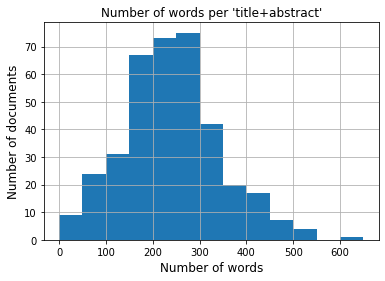

In [13]:
import matplotlib.pyplot as plt
longueurs = df_bibliovid.len
longueurs.hist(bins = np.arange(0,700,50))
plt.title("Number of words per 'title+abstract'")
plt.ylabel('Number of documents', fontsize=12)
plt.xlabel('Number of words', fontsize=12)
plt.show()

Pour pallier la perte d'information conséquente qui survient quand on coupe nos textes concaténés au 200 premiers tokens, on coupe nos textes en deux, et on attribue évidemment aux deux parties les attributs correspondants. On double également le nombre de données

In [16]:
part1 = []
for i in range(len(texts)):
  a = texts[i][:len(texts[i])//2]
  a = " ".join(a)
  part1.append(a)

part2 = []
for i in range(len(texts)):
  b = texts[i][len(texts[i])//2:]
  b = " ".join(b)
  part2.append(b)

In [17]:
df = df_bibliovid.copy()
df2 = df_bibliovid.copy()

In [18]:
df['cat_text'] = part1
df

,id,slug,title,has_other_authors,impact_factor,goals_plain,verbose_date,authors,document_link,specialties,category,journal,link,results,synthesis,strength_of_evidence_details,goals,methods,pubmed_id,doi,abstract,topics,author_list,publication_date,vect_specs,cat_text,len,len_sentence
0,769,body-mass-index-and-risk-for-intubation-or-dea...,Body Mass Index and Risk for Intubation or Dea...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...",- Déterminer si l'obésité est associée à l'int...,31.07.2020,Anderson MR,https://www.acpjournals.org/doi/10.7326/M20-3214,"[{'id': 4, 'name': 'Anesthésie-Réanimation'}, ...","{'id': 6, 'name': 'Pronostique', 'icon': 'icon...","{'id': 41, 'name': 'Ann Intern Med'}",https://www.acpjournals.org/doi/10.7326/M20-3214,*Description de l'échantillon: 2112 patients c...,- Environ 2-3% des patients atteints de la COV...,-cohorte pronostique- puissance de l'étude sup...,- Déterminer si l'obésité est associée à l'int...,Cohorte rétrospective portant sur 2466 patient...,32726151,10.7326/M20-3214,Obesity is a risk factor for pneumonia and acu...,"[Pronostique, Anesthésie-Réanimation, Infectio...","[{'id': 714, 'name': 'Anderson MR'}]",2020-07-31,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...",Body Mass Index and Risk for Intubation or Dea...,259,18
1,742,an-mrna-vaccine-against-sars-cov-2-preliminary...,An mRNA Vaccine against SARS-CoV-2 - Prelimina...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...",Développement du vaccin accéléré mRNA-1273 Mod...,15.07.2020,Jackson LA,https://www.nejm.org/doi/10.1056/NEJMoa2022483,"[{'id': 22, 'name': 'Immunité'}, {'id': 5, 'na...","{'id': 4, 'name': 'Thérapeutique', 'icon': 'ic...","{'id': 22, 'name': 'NEJM'}",https://www.nejm.org/doi/10.1056/NEJMoa2022483,"Après la première vaccination, les réponses an...",Le vaccin mRNA-1273 est plutôt bien toléré. De...,Les résultats du rapport ne sont que prélimina...,Développement du vaccin accéléré mRNA-1273 Mod...,"Essai de vaccination de Phase 1, ouvert inclua...",32663912,10.1056/NEJMoa2022483,The severe acute respiratory syndrome coronavi...,"[Thérapeutique, Immunité, Virologie, Infectiol...","[{'id': 690, 'name': 'Jackson LA'}]",2020-07-15,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",An mRNA Vaccine against SARS-CoV-2 - Prelimina...,269,14
2,739,pathophysiology-transmission-diagnosis-and-tre...,"Pathophysiology, Transmission, Diagnosis, and ...",True,"{'id': 2, 'name': 'Faible', 'posts_count': 505...",Etat des lieux bibliographique des connaissanc...,14.07.2020,Joost Wiersinga W,https://jamanetwork.com/journals/jama/fullarti...,"[{'id': 7, 'name': 'Transversale'}, {'id': 12,...","{'id': 2, 'name': 'Autres', 'icon': 'icon-other'}","{'id': 183, 'name': 'JAMA Network Open'}",https://jamanetwork.com/journals/jama/fullarti...,La transmission du SARS-CoV-2 est plus favorab...,Actualisation générale des connaissances (rech...,Revue orientée d'études pré-sélectionnées par ...,Etat des lieux bibliographique des connaissanc...,Bases de données indexées (générale et récente...,32648899,10.1001/jama.2020.12839,The coronavirus disease 2019 (COVID-19) pandem...,"[Autres, Transversale, Infectiologie]","[{'id': 687, 'name': 'Joost Wiersinga W'}]",2020-07-14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","Pathophysiology, Transmission, Diagnosis, and ...",436,33
3,735,introductions-and-early-spread-of-sars-cov-2-i...,Introductions and Early Spread of SARS-CoV-2 i...,True,"{'id': 4, 'name': 'Indéterminé', 'posts_count'...",Etudier comment l'épidémie de SARS-Cov-2 a com...,10.07.2020,Gambaro F,https://www.eurosurveillance.org/content/10.28...,"[{'id': 7, 'name': 'Transversale'}, {'id': 5, ...","{'id': 5, 'name': 'Epidémiologique', 'icon': '...","{'id': 46, 'name': 'Eurosurveillance'}",https://www.eurosurveillance.org/content/10.28...,Le virus a été introduit plusieurs fois dans l...,Le virus SARS-Cov-2 a été introduit plusieurs ...,Les données de cette étude semblent disponible...,Etudier comment l'épidémie de SARS

In [19]:
df2['cat_text'] = part2
df2

,id,slug,title,has_other_authors,impact_factor,goals_plain,verbose_date,authors,document_link,specialties,category,journal,link,results,synthesis,strength_of_evidence_details,goals,methods,pubmed_id,doi,abstract,topics,author_list,publication_date,vect_specs,cat_text,len,len_sentence
0,769,body-mass-index-and-risk-for-intubation-or-dea...,Body Mass Index and Risk for Intubation or Dea...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...",- Déterminer si l'obésité est associée à l'int...,31.07.2020,Anderson MR,https://www.acpjournals.org/doi/10.7326/M20-3214,"[{'id': 4, 'name': 'Anesthésie-Réanimation'}, ...","{'id': 6, 'name': 'Pronostique', 'icon': 'icon...","{'id': 41, 'name': 'Ann Intern Med'}",https://www.acpjournals.org/doi/10.7326/M20-3214,*Description de l'échantillon: 2112 patients c...,- Environ 2-3% des patients atteints de la COV...,-cohorte pronostique- puissance de l'étude sup...,- Déterminer si l'obésité est associée à l'int...,Cohorte rétrospective portant sur 2466 patient...,32726151,10.7326/M20-3214,Obesity is a risk factor for pneumonia and acu...,"[Pronostique, Anesthésie-Réanimation, Infectio...","[{'id': 714, 'name': 'Anderson MR'}]",2020-07-31,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","(interquartile range, 3 to 14 days), 533 patie...",259,18
1,742,an-mrna-vaccine-against-sars-cov-2-preliminary...,An mRNA Vaccine against SARS-CoV-2 - Prelimina...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...",Développement du vaccin accéléré mRNA-1273 Mod...,15.07.2020,Jackson LA,https://www.nejm.org/doi/10.1056/NEJMoa2022483,"[{'id': 22, 'name': 'Immunité'}, {'id': 5, 'na...","{'id': 4, 'name': 'Thérapeutique', 'icon': 'ic...","{'id': 22, 'name': 'NEJM'}",https://www.nejm.org/doi/10.1056/NEJMoa2022483,"Après la première vaccination, les réponses an...",Le vaccin mRNA-1273 est plutôt bien toléré. De...,Les résultats du rapport ne sont que prélimina...,Développement du vaccin accéléré mRNA-1273 Mod...,"Essai de vaccination de Phase 1, ouvert inclua...",32663912,10.1056/NEJMoa2022483,The severe acute respiratory syndrome coronavi...,"[Thérapeutique, Immunité, Virologie, Infectiol...","[{'id': 690, 'name': 'Jackson LA'}]",2020-07-15,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","GMT, 299,751, 782,719, and 1,192,154, respecti...",269,14
2,739,pathophysiology-transmission-diagnosis-and-tre...,"Pathophysiology, Transmission, Diagnosis, and ...",True,"{'id': 2, 'name': 'Faible', 'posts_count': 505...",Etat des lieux bibliographique des connaissanc...,14.07.2020,Joost Wiersinga W,https://jamanetwork.com/journals/jama/fullarti...,"[{'id': 7, 'name': 'Transversale'}, {'id': 12,...","{'id': 2, 'name': 'Autres', 'icon': 'icon-other'}","{'id': 183, 'name': 'JAMA Network Open'}",https://jamanetwork.com/journals/jama/fullarti...,La transmission du SARS-CoV-2 est plus favorab...,Actualisation générale des connaissances (rech...,Revue orientée d'études pré-sélectionnées par ...,Etat des lieux bibliographique des connaissanc...,Bases de données indexées (générale et récente...,32648899,10.1001/jama.2020.12839,The coronavirus disease 2019 (COVID-19) pandem...,"[Autres, Transversale, Infectiologie]","[{'id': 687, 'name': 'Joost Wiersinga W'}]",2020-07-14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",for supportive management of acute hypoxic res...,436,33
3,735,introductions-and-early-spread-of-sars-cov-2-i...,Introductions and Early Spread of SARS-CoV-2 i...,True,"{'id': 4, 'name': 'Indéterminé', 'posts_count'...",Etudier comment l'épidémie de SARS-Cov-2 a com...,10.07.2020,Gambaro F,https://www.eurosurveillance.org/content/10.28...,"[{'id': 7, 'name': 'Transversale'}, {'id': 5, ...","{'id': 5, 'name': 'Epidémiologique', 'icon': '...","{'id': 46, 'name': 'Eurosurveillance'}",https://www.eurosurveillance.org/content/10.28...,Le virus a été introduit plusieurs fois dans l...,Le virus SARS-Cov-2 a été introduit plusieurs ...,Les données de cette étude semblent disponible...,Etudier comment l'épidémie de SA

Df_bibliovid_augmented est le nouveau dataset contenant 2 fois plus de données

In [20]:
df_bibliovid_augmented = pd.concat([df,df2], ignore_index=True)
df_bibliovid_augmented

,id,slug,title,has_other_authors,impact_factor,goals_plain,verbose_date,authors,document_link,specialties,category,journal,link,results,synthesis,strength_of_evidence_details,goals,methods,pubmed_id,doi,abstract,topics,author_list,publication_date,vect_specs,cat_text,len,len_sentence
0,769,body-mass-index-and-risk-for-intubation-or-dea...,Body Mass Index and Risk for Intubation or Dea...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...",- Déterminer si l'obésité est associée à l'int...,31.07.2020,Anderson MR,https://www.acpjournals.org/doi/10.7326/M20-3214,"[{'id': 4, 'name': 'Anesthésie-Réanimation'}, ...","{'id': 6, 'name': 'Pronostique', 'icon': 'icon...","{'id': 41, 'name': 'Ann Intern Med'}",https://www.acpjournals.org/doi/10.7326/M20-3214,*Description de l'échantillon: 2112 patients c...,- Environ 2-3% des patients atteints de la COV...,-cohorte pronostique- puissance de l'étude sup...,- Déterminer si l'obésité est associée à l'int...,Cohorte rétrospective portant sur 2466 patient...,32726151,10.7326/M20-3214,Obesity is a risk factor for pneumonia and acu...,"[Pronostique, Anesthésie-Réanimation, Infectio...","[{'id': 714, 'name': 'Anderson MR'}]",2020-07-31,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...",Body Mass Index and Risk for Intubation or Dea...,259,18
1,742,an-mrna-vaccine-against-sars-cov-2-preliminary...,An mRNA Vaccine against SARS-CoV-2 - Prelimina...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...",Développement du vaccin accéléré mRNA-1273 Mod...,15.07.2020,Jackson LA,https://www.nejm.org/doi/10.1056/NEJMoa2022483,"[{'id': 22, 'name': 'Immunité'}, {'id': 5, 'na...","{'id': 4, 'name': 'Thérapeutique', 'icon': 'ic...","{'id': 22, 'name': 'NEJM'}",https://www.nejm.org/doi/10.1056/NEJMoa2022483,"Après la première vaccination, les réponses an...",Le vaccin mRNA-1273 est plutôt bien toléré. De...,Les résultats du rapport ne sont que prélimina...,Développement du vaccin accéléré mRNA-1273 Mod...,"Essai de vaccination de Phase 1, ouvert inclua...",32663912,10.1056/NEJMoa2022483,The severe acute respiratory syndrome coronavi...,"[Thérapeutique, Immunité, Virologie, Infectiol...","[{'id': 690, 'name': 'Jackson LA'}]",2020-07-15,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",An mRNA Vaccine against SARS-CoV-2 - Prelimina...,269,14
2,739,pathophysiology-transmission-diagnosis-and-tre...,"Pathophysiology, Transmission, Diagnosis, and ...",True,"{'id': 2, 'name': 'Faible', 'posts_count': 505...",Etat des lieux bibliographique des connaissanc...,14.07.2020,Joost Wiersinga W,https://jamanetwork.com/journals/jama/fullarti...,"[{'id': 7, 'name': 'Transversale'}, {'id': 12,...","{'id': 2, 'name': 'Autres', 'icon': 'icon-other'}","{'id': 183, 'name': 'JAMA Network Open'}",https://jamanetwork.com/journals/jama/fullarti...,La transmission du SARS-CoV-2 est plus favorab...,Actualisation générale des connaissances (rech...,Revue orientée d'études pré-sélectionnées par ...,Etat des lieux bibliographique des connaissanc...,Bases de données indexées (générale et récente...,32648899,10.1001/jama.2020.12839,The coronavirus disease 2019 (COVID-19) pandem...,"[Autres, Transversale, Infectiologie]","[{'id': 687, 'name': 'Joost Wiersinga W'}]",2020-07-14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","Pathophysiology, Transmission, Diagnosis, and ...",436,33
3,735,introductions-and-early-spread-of-sars-cov-2-i...,Introductions and Early Spread of SARS-CoV-2 i...,True,"{'id': 4, 'name': 'Indéterminé', 'posts_count'...",Etudier comment l'épidémie de SARS-Cov-2 a com...,10.07.2020,Gambaro F,https://www.eurosurveillance.org/content/10.28...,"[{'id': 7, 'name': 'Transversale'}, {'id': 5, ...","{'id': 5, 'name': 'Epidémiologique', 'icon': '...","{'id': 46, 'name': 'Eurosurveillance'}",https://www.eurosurveillance.org/content/10.28...,Le virus a été introduit plusieurs fois dans l...,Le virus SARS-Cov-2 a été introduit plusieurs ...,Les données de cette étude semblent disponible...,Etudier comment l'épidémie de SARS

In [21]:
if True:
  spec_dict=dict()
  spec_list=[]
  for elt in df_bibliovid_augmented['specialties'].values:
      spec_list.append(elt[0]['name'])
  spec_set=set(spec_list)
  i=0
  for elt in spec_set:
    spec_dict[elt]=i
    i+=1
  print(spec_dict)
  df_bibliovid_augmented['vect_specs']=df_bibliovid_augmented.topics.apply(lambda x: vectorize(x,spec_dict))
  #df_bibliovid_augmented['cat_text']=df_bibliovid_augmented['title']+df_bibliovid_augmented['abstract']
  df_bibliovid_augmented['len']=df_bibliovid_augmented['cat_text'].apply(lambda x: len(x.split(' ')))
  df_bibliovid_augmented['len_sentence']=df_bibliovid_augmented['cat_text'].apply(lambda x: len(x.split('.')))
  df_bibliovid_augmented=df_bibliovid_augmented.reset_index(drop=True)

{'Gynécologie Obstétrique': 0, 'Radiologie': 1, 'Hématologie': 2, 'Immunité': 3, 'Cardiologie et maladies métaboliques': 4, 'Psychiatrie': 5, 'Neurologie': 6, 'Anesthésie-Réanimation': 7, 'Hygiène': 8, 'Hépato-gastro-entérologie': 9, 'Virologie': 10, 'Infectiologie': 11, 'Pédiatrie': 12, 'Néphrologie': 13, 'Gériatrie': 14, 'Transversale': 15, 'Confinement/Déconfinement': 16}


On constate maintenant que la grande majorité des textes concaténés ont une longueur inférieure à 200 tokens

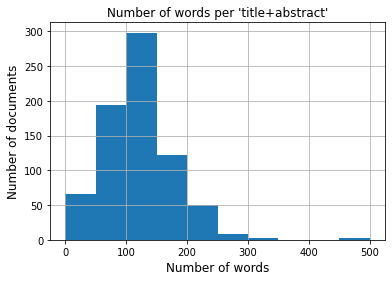

In [23]:
import matplotlib.pyplot as plt
longueurs = df_bibliovid_augmented.len
longueurs.hist(bins = np.arange(0,550,50))
plt.title("Number of words per 'title+abstract'")
plt.ylabel('Number of documents', fontsize=12)
plt.xlabel('Number of words', fontsize=12)
plt.show()

On voit que maintenant, lorsqu'on va utiliser notre modèle notamment la fonction "encode_plus", la longueur max fixée à 200 ne va plus faire perdre beaucoup d'information, par rapport à ce qu'on faisait précédemment, on est doublement gagnant, on a plus de données et on conserve "plus fidèlement" les données dont on dispose

On déroule maintenant le code de notre "baseline"

In [24]:
from tqdm import tqdm
input_ids=[]
attention_mask=[]
token_type_ids=[]
def make_dict(l):
    d=dict()
    for elt in l:
      d[elt]=''
    return d
def remove_ponctuation(text,ponctuation):
    return ''.join([elt for elt in list(text) if elt not in ponctuation])
def remove_stopword(text):
    return ' '.join([word for word in nltk.word_tokenize((text.lower())) if word not in make_dict(stopwords.words('english'))])
if True:
  ponctuation='''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  with  tqdm(total=df_bibliovid_augmented.shape[0], position=0) as progress:
            
    for index, row in df_bibliovid_augmented.iterrows(): #tqdm((df_litcovid.iterrows()),total=df_litcovid.shape[0],initial=0):
      x=tokenizer.encode_plus(
                remove_stopword(remove_ponctuation(row.cat_text,ponctuation)),
                add_special_tokens=True,
                max_length=200,
                pad_to_max_length=True,
                padding=False,
                return_token_type_ids=True
            )
      input_ids.append(x['input_ids'])
      attention_mask.append(x['attention_mask'])
      token_type_ids.append(x['token_type_ids'])
      progress.update()

  0%|          | 0/742 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 742/742 [00:11<00:00, 65.19it/s]


In [25]:
if True:
  a=df_bibliovid_augmented.copy()
  a['input_ids']=input_ids
  a['attention_mask']=attention_mask
  a['token_type_ids']=token_type_ids
  a.head()

In [26]:
a

,id,slug,title,has_other_authors,impact_factor,goals_plain,verbose_date,authors,document_link,specialties,category,journal,link,results,synthesis,strength_of_evidence_details,goals,methods,pubmed_id,doi,abstract,topics,author_list,publication_date,vect_specs,cat_text,len,len_sentence,input_ids,attention_mask,token_type_ids
0,769,body-mass-index-and-risk-for-intubation-or-dea...,Body Mass Index and Risk for Intubation or Dea...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...",- Déterminer si l'obésité est associée à l'int...,31.07.2020,Anderson MR,https://www.acpjournals.org/doi/10.7326/M20-3214,"[{'id': 4, 'name': 'Anesthésie-Réanimation'}, ...","{'id': 6, 'name': 'Pronostique', 'icon': 'icon...","{'id': 41, 'name': 'Ann Intern Med'}",https://www.acpjournals.org/doi/10.7326/M20-3214,*Description de l'échantillon: 2112 patients c...,- Environ 2-3% des patients atteints de la COV...,-cohorte pronostique- puissance de l'étude sup...,- Déterminer si l'obésité est associée à l'int...,Cohorte rétrospective portant sur 2466 patient...,32726151,10.7326/M20-3214,Obesity is a risk factor for pneumonia and acu...,"[Pronostique, Anesthésie-Réanimation, Infectio...","[{'id': 714, 'name': 'Anderson MR'}]",2020-07-31,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...",Body Mass Index and Risk for Intubation or Dea...,129,8,"[101, 2303, 3742, 5950, 3891, 20014, 19761, 35...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,742,an-mrna-vaccine-against-sars-cov-2-preliminary...,An mRNA Vaccine against SARS-CoV-2 - Prelimina...,True,"{'id': 3, 'name': 'Intermédiaire', 'posts_coun...",Développement du vaccin accéléré mRNA-1273 Mod...,15.07.2020,Jackson LA,https://www.nejm.org/doi/10.1056/NEJMoa2022483,"[{'id': 22, 'name': 'Immunité'}, {'id': 5, 'na...","{'id': 4, 'name': 'Thérapeutique', 'icon': 'ic...","{'id': 22, 'name': 'NEJM'}",https://www.nejm.org/doi/10.1056/NEJMoa2022483,"Après la première vaccination, les réponses an...",Le vaccin mRNA-1273 est plutôt bien toléré. De...,Les résultats du rapport ne sont que prélimina...,Développement du vaccin accéléré mRNA-1273 Mod...,"Essai de vaccination de Phase 1, ouvert inclua...",32663912,10.1056/NEJMoa2022483,The severe acute respiratory syndrome coronavi...,"[Thérapeutique, Immunité, Virologie, Infectiol...","[{'id': 690, 'name': 'Jackson LA'}]",2020-07-15,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",An mRNA Vaccine against SARS-CoV-2 - Prelimina...,134,6,"[101, 28848, 17404, 18906, 9363, 2615, 2475, 8...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,739,pathophysiology-transmission-diagnosis-and-tre...,"Pathophysiology, Transmission, Diagnosis, and ...",True,"{'id': 2, 'name': 'Faible', 'posts_count': 505...",Etat des lieux bibliographique des connaissanc...,14.07.2020,Joost Wiersinga W,https://jamanetwork.com/journals/jama/fullarti...,"[{'id': 7, 'name': 'Transversale'}, {'id': 12,...","{'id': 2, 'name': 'Autres', 'icon': 'icon-other'}","{'id': 183, 'name': 'JAMA Network Open'}",https://jamanetwork.com/journals/jama/fullarti...,La transmission du SARS-CoV-2 est plus favorab...,Actualisation générale des connaissances (rech...,Revue orientée d'études pré-sélectionnées par ...,Etat des lieux bibliographique des connaissanc...,Bases de données indexées (générale et récente...,32648899,10.1001/jama.2020.12839,The coronavirus disease 2019 (COVID-19) pandem...,"[Autres, Transversale, Infectiologie]","[{'id': 687, 'name': 'Joost Wiersinga W'}]",2020-07-14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","Pathophysiology, Transmission, Diagnosis, and ...",218,14,"[101, 4130, 7361, 10536, 20763, 6483, 6726, 11...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,735,introductions-and-early-spread-of-sars-cov-2-i...,Introductions and Early Spread of SARS-CoV-2 i...,True,"{'id': 4, 'name': 'Indéterminé', 'posts_count

In [27]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  200


In [28]:
b = a[['cat_text', 'vect_specs']]
b

,cat_text,vect_specs
0,Body Mass Index and Risk for Intubation or Dea...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
1,An mRNA Vaccine against SARS-CoV-2 - Prelimina...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
2,"Pathophysiology, Transmission, Diagnosis, and ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,Introductions and Early Spread of SARS-CoV-2 i...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,How to Safely Reopen Colleges and Universities...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
...,...,...
737,17 patients underwent Cesarean delivery with a...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
738,"expert consensus paper, two national guideline...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
739,17 days after the last virus exposure. The chi...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
740,cities had already received many infected trav...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


On garde les mêmes paramètres que dans les notebooks originels afin de pouvoir comparer les résultats

In [29]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 1
LEARNING_RATE = 3e-5 #conseillé sur le papier
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [30]:
class CustomDataset(Dataset):

    def __init__(self, dataframe):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.abstract #ajouter le titre
        self.targets = self.data.vect_specs
        self.input_ids=[]
        self.attention_mask=[]
        self.token_type_ids=[]
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        self.input_ids=self.data.input_ids.iloc[index]
        self.attention_mask=self.data.attention_mask.iloc[index]
        self.token_type_ids=self.data.token_type_ids.iloc[index]
        return {
            'ids': torch.tensor(self.input_ids, dtype=torch.long),
            'mask': torch.tensor(self.attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(self.token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [31]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
#train_dataset=df_litcovid.sample(frac=train_size,random_state=200)
#test_dataset=df_litcovid.drop(train_dataset.index).reset_index(drop=True)
train_dataset=a.sample(frac=train_size,random_state=200)
test_dataset=a.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


#print("FULL Dataset: {}".format(df_litcovid.shape))
print("FULL Dataset: {}".format(a.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset)
testing_set = CustomDataset(test_dataset)

FULL Dataset: (742, 31)
TRAIN Dataset: (594, 31)
TEST Dataset: (148, 31)


In [32]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

Création de notre modèle à partir de Bert

In [33]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        #for param in self.l1.parameters():
        #  param.requires_grad = False
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 17)
    
    def forward(self, ids, mask, token_type_ids):
        output1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output1[1])
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [34]:
def model_parameters_number(model):
  l=[]
  for parameter in model.parameters():
      l.append(parameter)
  s=0
  for el in l:
    try :s+=el.shape[0]*el.shape[1]
    except: s+=el.shape[0]
  return s
model_parameters_number(model)

109495313

In [35]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [36]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [37]:
def train(epochs):
    model.train()
    for epoch in range(epochs):
        for _,data in tqdm(enumerate(training_loader),total=len(training_loader),position=0,leave=True):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)
            optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            if _%len(training_loader)==0:
                print(f'Epoch: {epoch}, Loss:  {loss.item()}')
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    

In [38]:
train(30)

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 0, Loss:  0.6713228821754456


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 1, Loss:  0.39670175313949585


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 2, Loss:  0.3185848891735077


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 3, Loss:  0.2511932849884033


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 4, Loss:  0.24087470769882202


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 5, Loss:  0.24176006019115448


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 6, Loss:  0.24847176671028137


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 7, Loss:  0.20114965736865997


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 8, Loss:  0.20834246277809143


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 9, Loss:  0.20049799978733063


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 10, Loss:  0.20613627135753632


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 11, Loss:  0.16195909678936005


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 12, Loss:  0.16270631551742554


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 13, Loss:  0.15006601810455322


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 14, Loss:  0.13337060809135437


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 15, Loss:  0.15555521845817566


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 16, Loss:  0.12181585282087326


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 17, Loss:  0.10190857201814651


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 18, Loss:  0.0856439620256424


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 19, Loss:  0.11049211770296097


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 20, Loss:  0.06920569390058517


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 21, Loss:  0.0988878384232521


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 22, Loss:  0.08755286037921906


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 23, Loss:  0.05881170555949211


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 24, Loss:  0.06850453466176987


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 25, Loss:  0.06188945099711418


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 26, Loss:  0.06041286885738373


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 27, Loss:  0.06309868395328522


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 28, Loss:  0.040545541793107986


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 29, Loss:  0.047069549560546875


100%|██████████| 19/19 [00:21<00:00,  1.13s/it]


In [39]:
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader),total=len(testing_loader),position=0,leave=True):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [40]:
for epoch in range(EPOCHS):
    outputs, targets = validation(epoch)
    outputs = np.array(outputs) >= 0.4
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")

100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

Accuracy Score = 0.4527027027027027
F1 Score (Micro) = 0.6650943396226414
F1 Score (Macro) = 0.5686862014261396



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [41]:
torch.save(model.state_dict(), '/content/drive/MyDrive/spec_model')

On obtient de biens meilleurs résultats en effectuant ce découpage en deux des textes concatenés. On reste loin d'avoir des résultats satisfaisant, mais c'est un premier pas.